In [1]:
import numpy as np
import mnist

import matplotlib.pyplot as plt
%matplotlib inline

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [2]:
def xavier_init(channel_in, channel_out, constant = 1): 
    """
    Xavier initialization of network weights
    """
    
    low = -constant * np.sqrt(6.0 / (channel_in + channel_out)) 
    high = constant * np.sqrt(6.0 / (channel_in + channel_out))
    return tf.random_uniform((channel_in, channel_out), minval = low, maxval = high, dtype=tf.float32)

### Define Model

In [3]:
class VAE(object):
    
    def __init__(self, network_architecture, learning_rate=0.001, batch_size=100):
        """
        Set up the VAE model.
        """
        
        # Set model parameters
        self.network_architecture = network_architecture
        self.lr = learning_rate
        self.batch_size = batch_size
        
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Forward pass
        self.forward()
        
        # Backward pass
        self.backward()

        # Initialize the variables and launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
        
    def initialize_weights(self, n_hidden_enc_1, n_hidden_enc_2, 
                           n_hidden_dec_1, n_hidden_dec_2, n_input, n_z):
        """
        Initialize weights of the network layers.
        """
        
        network_weights = dict()
        network_weights['encoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_input, n_hidden_enc_1)),
            'W2': tf.Variable(xavier_init(n_hidden_enc_1, n_hidden_enc_2)),
            'W_mu': tf.Variable(xavier_init(n_hidden_enc_2, n_z)),
            'W_logvar': tf.Variable(xavier_init(n_hidden_enc_2, n_z))}
        network_weights['encoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_enc_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_enc_2], dtype=tf.float32)),
            'b_mu': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'b_logvar': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        network_weights['decoder_weights'] = {
            'W1': tf.Variable(xavier_init(n_z, n_hidden_dec_1)),
            'W2': tf.Variable(xavier_init(n_hidden_dec_1, n_hidden_dec_2)),
            'W_out': tf.Variable(xavier_init(n_hidden_dec_2, n_input))}
        network_weights['decoder_bias'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_dec_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_dec_2], dtype=tf.float32)),
            'b_out': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return network_weights
 

    def encode(self, weights, bias):
        """
        Use the encoder model to map the input data to the latent space.
        """
        
        hidden_1 = tf.nn.relu(tf.add(tf.matmul(self.x, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        mu = tf.add(tf.matmul(hidden_2, weights['W_mu']), bias['b_mu'])
        logvar = tf.add(tf.matmul(hidden_2, weights['W_logvar']), bias['b_logvar'])
        return (mu, logvar)

    def decode(self, weights, bias):
        """
        Use the decoder model to reconstruct the input data.
        """
        
        hidden_1 = tf.nn.leaky_relu(tf.add(tf.matmul(self.z, weights['W1']), bias['b1'])) 
        hidden_2 = tf.nn.leaky_relu(tf.add(tf.matmul(hidden_1, weights['W2']), bias['b2'])) 
        recon_x = tf.nn.sigmoid(tf.add(tf.matmul(hidden_2, weights['W_out']), bias['b_out']))
        return recon_x
    
    
    def forward(self):
        """
        Build the VAE network.
        """
        
        # Initialize weights and bias
        network_weights = self.initialize_weights(**self.network_architecture)

        # Use encoder model to obtain latent z
        self.mu, self.logvar = self.encode(network_weights["encoder_weights"], 
                                      network_weights["encoder_bias"])

        # Draw sample z from Gaussian using reparametrization trick
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32)
        self.z = tf.add(self.mu, tf.multiply(tf.sqrt(tf.exp(self.logvar)), eps))

        # Use decoder model to obtain the reconstructed input
        self.recon_x = self.decode(network_weights["decoder_weights"],
                                    network_weights["decoder_bias"])
            
            
    def backward(self):
        """
        Calculate gradients using backpropagation and update weights using Adam optimizer.
        """
        
        rec_loss = - tf.reduce_sum(self.x * tf.log(1e-8 + self.recon_x)
                           + (1 - self.x) * tf.log(1e-8 + 1 - self.recon_x), 1)
      
        kl = -0.5 * tf.reduce_sum(1 + self.logvar - tf.square(self.mu) - tf.exp(self.logvar), 1)
        
        self.loss = tf.reduce_mean(rec_loss + kl)   
       
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.lr).minimize(self.loss)
        
    def train(self, X):
        """
        Train model based on mini-batch of input data.
        Return loss of mini-batch.
        """
        
        opt, loss = self.sess.run((self.optimizer, self.loss), 
                                                feed_dict={self.x: X})
        return loss
    
    def transform(self, X):
        """
        Transform data by mapping it into the latent space.
        """
        # Note: This maps to mean of distribution, we could alternatively sample from Gaussian distribution
        return self.sess.run((self.mu, self.logvar), feed_dict={self.x: X})
    
    def generate(self, mu = None):
        """ 
        Generate data by sampling from the latent space.        
        """
        if mu is None:
            # Data is alternatively generated from the prior in the latent space
            mu = np.random.normal(size = self.network_architecture["n_z"])

        return self.sess.run(self.recon_x, feed_dict={self.z: mu})
    
    def reconstruct(self, X):
        """ 
        Reconstruct the given input data. 
        """
        
        return self.sess.run(self.recon_x, feed_dict={self.x: X})

### Training

In [4]:
def train_mnist(network_architecture, images,
                learning_rate=0.001, batch_size=100, n_epoch=10):
    """
    Train the VAE model on the MNIST data set.
    """
    
    vae = VAE(network_architecture, learning_rate=learning_rate, batch_size=batch_size)
    
    train_size = len(images)
    train_data = images.reshape((train_size, 784)) / 255 # normalize to [0,1]
    
    for epoch in range(n_epoch):
        
        avg_loss = 0.
        n_batch = int(train_size / batch_size) 

        for idx in range(n_batch):
            train_batch = train_data[idx * batch_size:idx * batch_size + batch_size]
            loss = vae.train(train_batch)
            avg_loss += loss / train_size * batch_size

        print("Epoch:", "%d/%d" % (epoch+1, n_epoch), 
              "Loss =", "{:.4f}".format(avg_loss))
        
    return vae

In [5]:
network_architecture = dict(n_hidden_enc_1=500, 
                             n_hidden_enc_2=500, 
                             n_hidden_dec_1=500, 
                             n_hidden_dec_2=500, 
                             n_input=784, 
                             n_z=100) 

vae = train_mnist(network_architecture, mnist.train_images(), n_epoch = 200)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch: 1/200 Loss = 164.6328
Epoch: 2/200 Loss = 124.9651
Epoch: 3/200 Loss = 116.9161
Epoch: 4/200 Loss = 113.0834
Epoch: 5/200 Loss = 110.4787
Epoch: 6/200 Loss = 108.6359
Epoch: 7/200 Loss = 107.4994
Epoch: 8/200 Loss = 106.4819
Epoch: 9/200 Loss = 105.6952
Epoch: 10/200 Loss = 105.1213
Epoch: 11/200 Loss = 104.5814
Epoch: 12/200 Loss = 103.9522
Epoch: 13/200 Loss = 103.5108
Epoch: 14/200 Loss = 103.0897
Epoch: 15/200 Loss = 102.8289
Epoch: 16/200 Loss = 102.4243
Epoch: 17/200 Loss = 102.1996
Epoch: 18/200 Loss = 101.9845
Epoch: 19/200 Loss = 101.7286
Epoch: 20/200 Loss = 101.5520
Epoch: 21/200 Loss = 101.2993
Epoch: 22/200 Loss = 101.1506
Epoch: 23/200 Loss = 101.0281
Epoch: 24/200 Loss = 100.8513
Epoch: 25/200 Loss = 100.7082
Epoch: 26/200 Loss = 100.5033
Epoch: 27/200 Loss = 100.4141
Epoch: 28/200 Loss = 100.2769
Epoch: 29/200 Loss = 100.2472
Epoch: 30/200 Loss = 100.0456
Epoch: 31/200 Loss = 99.9535

### Image Reconstruction

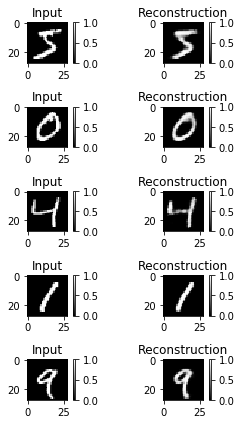

In [7]:
images = mnist.train_images()
x_sample = (images.reshape((60000, 784)) / 255)[:100,]
recon_x = vae.reconstruct(x_sample)

plt.figure(figsize=(4, 6))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(recon_x[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

In [8]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

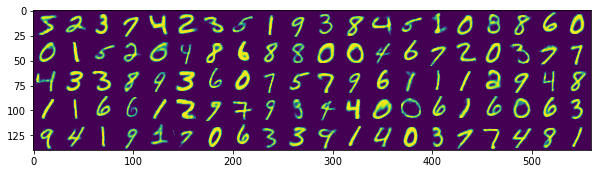

In [10]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(recon_x))

#### Compute Reconstruction Error

In [12]:
def calculate_recon_error(X, recon_X):
    """
    Compute the reconstruction error.
    """
    rec_loss = - np.sum(X * np.log(1e-8 + recon_X)
                           + (1 - X) * np.log(1e-8 + 1 - recon_X), 1)
    return np.mean(rec_loss)

In [13]:
calculate_recon_error(x_sample, recon_x)

73.78339026240921